# Multi-Class Object Detector for 3YP
Using Faster R-CNN (ResNet50) trained on COCO dataset

By Jiale Wang


---



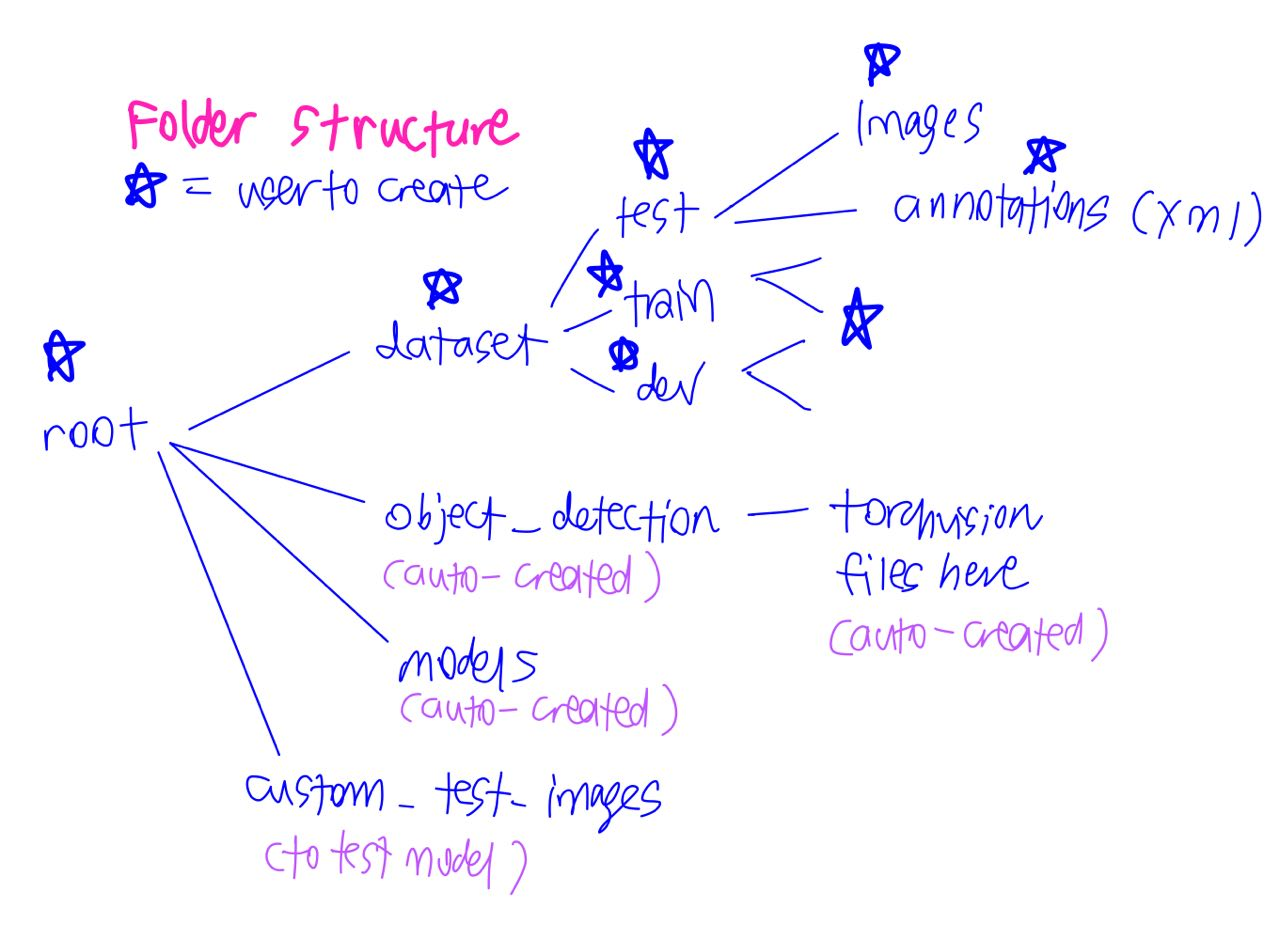

# CUDA and torch versions

In [2]:
# Check cuda version
!nvidia-smi

Tue Apr  5 13:58:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Install older torch
# !pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0

In [4]:
import torch
print(torch.__version__)

1.9.0+cu102


# Import Libraries and Mount GDrive

In [5]:
%matplotlib inline
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time as time
import math
import os

from PIL import ImageFont, ImageDraw, Image

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive




---


# SET UP
Follow the next few steps and you're (hopefully) done

### Note: Any directories with "#CHANGE_ME" needs to be changed to suit dataset.

## STEP 1: Specify Root Directory

In [7]:
# ROOT DIRECTORY in which datasets/models will be built in
root = "/content/drive/My Drive/3YPObjDet"                   # CHANGE_ME
os.chdir(root)
os.getcwd()

'/content/drive/My Drive/3YPObjDet'

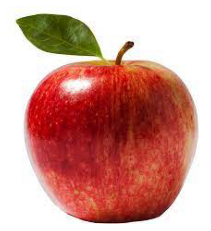

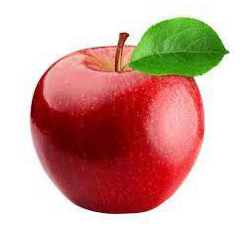

In [8]:
dataset_directory = f"{root}/datasets"                       # CHANGE_ME
dataset_subfolders = ['train_val', 'test']                                # CHANGE_ME - may have test/train/dev folders if needed

train_directory = os.path.join(dataset_directory, dataset_subfolders[0])    # CHANGE_ME
test_directory = os.path.join(dataset_directory, dataset_subfolders[1])     # CHANGE_ME to [1] if needed

directories_list = [train_directory, test_directory]                              

# Check if images correctly downloaded
for i in range(2,4):
  image = Image.open(os.path.join(train_directory, "images", f"apple ({i}).jpg"))        # CHANGE_ME
  plt.imshow(image)
  plt.axis('off')
  plt.show()

In [9]:
!pwd

/content/drive/My Drive/3YPObjDet


## STEP 2: Get xml labels and convert to csv, then pandas df

In [10]:
# Requires xml_to_csv.py file (see "critical support files folder")
# from xml_to_csv import xml_to_csv

In [11]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [12]:
# # # DO NOT RUN ANYMORE! CSV ALREADY GENERATED

# # Convert xml files to csv
# ds_old = 0

# for i, ds in enumerate(directories_list):
#   if ds_old != ds:      # If statement to check if directories are repeated
#     image_path = os.path.join(ds, 'annotations')
#     xml_df = xml_to_csv(image_path)
#     print(xml_df)
#     xml_df.to_csv(f"labels_{dataset_subfolders[i]}.csv")
#     print('Successfully converted xml to csv. Output file in ROOT directory')
#     ds_old = ds

In [13]:
# Convert all file names to end with jpg (did so due to labelling error) - do not run anymore

# temp = pd.read_csv(train_labels_savefile)

# # temp["filename"][0][-3:]

# for i in range(len(temp["filename"])):
#   if temp["filename"][i][-3:] != "jpg":
#     start = temp["filename"][i][:-3]
#     temp.at[i,"filename"] = f"{start}jpg"

# temp.to_csv(f"{root}/labels_test.csv")

In [14]:
# Convert to pandas dataframe and check if correct
# Note: Make sure to import all (train, dev, test) CSVs

train_labels_savefile = os.path.join(root, "labels_train_val.csv")                 # CHANGE_ME
test_labels_savefile = os.path.join(root, "labels_test.csv")                  # CHANGE_ME

labels_df = pd.read_csv(train_labels_savefile)   
labels_df

,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,apple (2).jpg,214,236,apple,17,58,207,235
1,1,apple (3).jpg,230,220,apple,22,37,202,212
2,2,apple (4).jpg,225,225,apple,24,5,200,224
3,3,apple (5).jpg,259,194,apple,48,9,237,182
4,4,apple (6).jpg,208,242,apple,11,54,197,232
...,...,...,...,...,...,...,...,...,...
128,128,pear (1).jpg,275,183,pear,151,18,229,173
129,129,pear (1).jpg,275,183,pear,99,24,161,157
130,130,pear (1).jpg,275,183,pear,53,16,116,145
131,131,milk (1).jpg,100,100,milk,26,1,74,94


In [15]:
# DO NOT EDIT
# Replace class labels with numbers

# Get list of classes in dataframe, including "0" background layer
list_of_classes = np.array([0])
print(list_of_classes)
list_of_classes = np.append(list_of_classes, np.unique(labels_df["class"]))

# Get number of classes, including bg class
num_classes = len(list_of_classes)

# Map class names to numbers (e.g. 0 = background, 1 = flammable etc..)
for j in range(len(labels_df["class"])):
  class_index = np.where(list_of_classes == labels_df["class"][j])[0][0]
  labels_df.at[j,"class"] = class_index

[0]


In [16]:
list_of_classes

array([0, 'apple', 'crisps', 'milk', 'pear'], dtype=object)

In [17]:
# Check if class replaced correctly
labels_df

,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,apple (2).jpg,214,236,1,17,58,207,235
1,1,apple (3).jpg,230,220,1,22,37,202,212
2,2,apple (4).jpg,225,225,1,24,5,200,224
3,3,apple (5).jpg,259,194,1,48,9,237,182
4,4,apple (6).jpg,208,242,1,11,54,197,232
...,...,...,...,...,...,...,...,...,...
128,128,pear (1).jpg,275,183,4,151,18,229,173
129,129,pear (1).jpg,275,183,4,99,24,161,157
130,130,pear (1).jpg,275,183,4,53,16,116,145
131,131,milk (1).jpg,100,100,3,26,1,74,94


# STEP 3: Check if labels match image

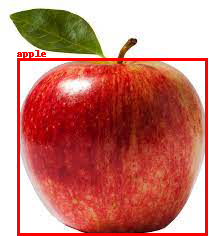

In [18]:
idx = 2       # Image Index

# Open Image
image = Image.open(os.path.join(train_directory, "images", f"apple ({idx}).jpg"))          # CHANGE_ME

target_filename = f"apple ({idx}).jpg"                                                     # CHANGE ME
true_idx = labels_df["filename"] == target_filename

# Coords from csv file
xmin = labels_df["xmin"][true_idx]
ymin = labels_df["ymin"][true_idx]

xmax = labels_df["xmax"][true_idx]
ymax = labels_df["ymax"][true_idx]


draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline = "red", width=3)
class_label_print = list_of_classes[int(labels_df["class"][true_idx])]
draw.text((xmin, ymin-10), text = class_label_print, fill = "red")
image

# STEP 4: SPECIFY MODEL & TRAINING PARAMETERS
# CHANGE_ME

In [72]:
# OPTIMIZER
# Learning Rate & Step Size for lr scheduler
lr = 0.01
stp = 3           # Decreases learning rate every 3 epochs
gma = 0.1         # Gamma - 0.1 means decrease lr by 10x
mmtm = 0.9        # Momemtum for SGD
decay = 0.0005

### TODO: ****** Hyperparameter tuning is to figure out the optimal lr, stp, gma ******


# DATALOADER
# Determine number of subprocesses for dataloader
# 2 is recommended, but 4 still works. Too high may cause slow-down
num_workers = 2

# Batch size - too large may cause running out of memory!
batch_size_train = 1
batch_size_test = 1

# Seed for randomly splitting train and test (validation) set
# random_seed = 1006
random_seed = 1500

# TRAINING
num_epochs = 10
printing_freq = 10      # Frequency of displaying results (NOT BATCH SIZE!)
percentage_test = 0.2   # % of dataset to use as test (e.g. 0.2 = 20% test, 80% train)

# TESTING
# Required CONF threshold to draw box and be certain of right detection
# Put lower threshold if model is highly accurate
threshold= 0.75


# MODEL NAME
model_name = "vis_3yp_model1"

# Import torchvision libraries

In [20]:
# Create Folder for Object Detection model and files (torchvision)
obj_det_directory = f"{root}/object_detection"
# os.mkdir(obj_det_directory)

# ! git clone https://github.com/pytorch/vision.git

In [21]:
# Copy some py files for importing later

# from shutil import copy
# copy("vision/references/detection/utils.py", "vision")
# copy("vision/references/detection/transforms.py", "vision")
# copy("vision/references/detection/coco_eval.py", "vision")
# copy("vision/references/detection/engine.py", "vision")
# copy("vision/references/detection/coco_utils.py", "vision")

In [22]:
!pwd

/content/drive/My Drive/3YPObjDet


# Using Faster R-CNN model pre-trained on COCO
Options:

Faster R-CNN ResNet-50 FPN

Mask R-CNN ResNet-50 FPN


In [23]:
import torch
import torchvision
import torch.utils.data

# Import selected model - Faster R-CNN ResNet-50 FPN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Mask R-CNN ResNet-50 FPN - KIV for now!
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
%cd /content/drive/My Drive/3YPObjDet                                    
os.chdir("vision") 

from engine import train_one_epoch, evaluate

import utils
# from torchvision import transforms as T   # For flipping images etc
import transforms as T
# import torchvision.transforms as T

os.chdir(obj_det_directory)

/content


In [24]:
!pwd

/content/drive/My Drive/3YPObjDet/object_detection


Shld be object Detection dir

In [25]:
print(torch.__version__)
print(torchvision.__version__)

1.9.0+cu102
0.10.0+cu102


# Extract coordinates of box and class label

In [26]:
# Function to extract data labels
# "labels" from previously read pandas df of csv file

def parse_one_annot(path_to_data_file, filename):
  target_row = labels_df[labels_df["filename"] == filename]                 # Extracts one row matching "filename"
  boxes_array = target_row[["xmin", "ymin", "xmax", "ymax"]].values         # Extracts bounding coords from that row
  class_type = target_row[["class"]].values
   
  return boxes_array, class_type.astype(str).astype(int)

# Set up Custom Dataset Class
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

ataset should inherit from the standard torch.utils.data.

Dataset class, and implement _ _ len _ _ and _ _ getitem _ _


"_ _ getitem _ _" should return:



1. PIL Image of size (Height, Width)
2. target: a dict with the following fields:
    * __boxes__ (FloatTensor[N, 4]): coordinates of the N bounding boxes in [x0, y0, x1, y1] format
    * __labels__ (Int64Tensor[N]): label (e.g. raccoon) for each bounding box. 0 represents always the background class.
    * __image_id__ (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * __area__ (Tensor[N]):  area of the bounding box. Used to separare small/medium/large boxes in mAP
    * __iscrowd__(UInt8Tensor[N]) - 8-bit integer (unsigned): instances with iscrowd=True will be ignored during evaluation




In [27]:
class MyCustomDataset(torch.utils.data.Dataset):
  # Transforms is for data augmentation, by default None but a transforms helper fn is used (see below)
  
  def __init__(self, root, data_file, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = sorted(os.listdir(os.path.join(root, "images")))      # Navigate to image directory
    self.path_to_data_file = data_file

    # print(self.imgs)

  # Get image information, returning required tensor "target"
  def __getitem__(self, idx):

    # PART 0: GET IMAGE PIL FILE
    # load EACH image and its bounding boxes
    # print(f"curr idx is: {idx}")
    img_path = os.path.join(self.root, "images", self.imgs[idx])        # Get address of each image
    img = Image.open(img_path).convert("RGB")                           # Open image and convert to RGB
  
    # PART 1: GET COORDS OF BOUNDING BOXES   
    box_list, class_type_num = parse_one_annot(self.path_to_data_file,                  # Get bounding box coords for this image
    self.imgs[idx])
    boxes = torch.as_tensor(box_list, dtype=torch.float32)              # Convert array of coords to tensor

    # PART 2: GET CLASS LABELS
    # To handle multiple classes
    class_type_num = class_type_num.transpose()[0] 
    labels = torch.as_tensor(class_type_num, dtype=torch.int64)
    
    # PART 3: GET IMAGE_IDs
    image_id = torch.tensor([idx])

    # PART 4: COMPUTE AREA
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

    # PART 5: suppose all instances are not crowd so none will be ignored
    num_objs = len(box_list)
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # ASSEMBLE REQUIRED TARGET DICTIONARY
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd


    if self.transforms is not None:
        img, target = self.transforms(img, target)
    return img, target


  def __len__(self):
    return len(self.imgs)

In [28]:
# Testing if the above works - should return tuple with 1. PIL image 2. target dict

# Define dataset (images) and labels location for train
dataset = MyCustomDataset(root= train_directory, 
                        data_file= train_labels_savefile)

# Test if successful
dataset.__getitem__(2)

(<PIL.Image.Image image mode=RGB size=260x194 at 0x7F56D913DF10>,
 {'area': tensor([10400., 15750.]), 'boxes': tensor([[ 11.,  17., 115., 117.],
          [ 99.,  32., 224., 158.]]), 'image_id': tensor([2]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1])})

In [29]:
dataset.__getitem__(79)

(<PIL.Image.Image image mode=RGB size=214x235 at 0x7F56D8EC7050>,
 {'area': tensor([14204.]),
  'boxes': tensor([[ 57.,  49., 163., 183.]]),
  'image_id': tensor([79]),
  'iscrowd': tensor([0]),
  'labels': tensor([4])})

# Set up Faster R-CNN ResNet50 FPN Model
Transfer Learning via finetunning from pretrained model on COCO

In [30]:
# Set up model with required no. of classes

def get_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

# Data Augmentation to broaden dataset


*   Horizontal Flip
*   ColorJitter (Brightness, Contrast, Saturation)
*   Random IOU Crop


In [31]:
def augment_image(train):
    # Create new list of original and transformed images
    transforms = []

    # converts the PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    # transforms.append(T.PILToTensor())

    # Augments image only if during training stage; train == True:
    if train:
      # Randomly augment the training images and ground-truths for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
      # transforms.append(T.RandomPhotometricDistort())
      # transforms.append(T.RandomIoUCrop())
    #   # transforms.append(T.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0))
    #   # transforms.append(T.Grayscale(num_output_channels=3))
    return T.Compose(transforms)

# Split test and train data

In [32]:
# Get training dataset
dataset = MyCustomDataset(root= train_directory, 
                        data_file= train_labels_savefile, 
                        transforms = augment_image(train=True))


# Get testing dataset - same as that for training BUT no augmentation. 
# TODO: Experiment with a different dataset
# dataset_test = MyCustomDataset(root= test_directory, 
#                         data_file= test_labels_savefile, 
#                         transforms = augment_image(train=False))

dataset_test = MyCustomDataset(root= train_directory, 
                        data_file= train_labels_savefile, 
                        transforms = augment_image(train=False))

# Split the dataset into train and test set
torch.manual_seed(random_seed)     # Set my own seed for random number generation for consistency

# Randomly mix up numbers from 1 to length of dataset
indices = torch.randperm(len(dataset)).tolist()

# Try to preserve distribution of positive and negative in classification problems
# but for obj det permutating data is fine

# NEGATIVE images - datasets without the class in it
# Then taking random indcies will have to maintian distribution of +ve and -ve

# Take 20% test, 80% train split
num_test = math.floor(len(dataset)*percentage_test)

dataset = torch.utils.data.Subset(dataset, indices[:-num_test])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-num_test:])


# Define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=batch_size_train, shuffle=True, num_workers=num_workers, 
              collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
                  dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=num_workers,
                  collate_fn=utils.collate_fn)

print(f"We have: {len(indices)} examples, {len(dataset)} are training and {len(dataset_test)} testing")

We have: 100 examples, 80 are training and 20 testing


# Set up Model - Currently training in GPU

In [33]:
# Check if GPU available and train on GPU
print(torch.cuda.is_available())
device = torch.device('cuda')
# device = torch.device('cpu')

True


In [34]:
# get the model using our helper function
model = get_model(num_classes)

# move model to the CUDA device - NEED TO BE DONE BEFORE CONSTRUCTING OPTIMIZERS (torch.optim)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=lr,
                            momentum=mmtm, weight_decay=decay)


# Learning Rate Scheduler: decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stp,
                                               gamma=gma)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

# Import Tensorboard to log training (running below)

In [35]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

# %load_ext tensorboard

In [36]:
# Check torch version
print(torch.__version__)

1.9.0+cu102


# Doing the actual training

In [310]:
for epoch in range(num_epochs):

  # train for one epoch, printing every 10 iterations
  # Return loss etc. data from "train_one_epoch" fn in engine.py
  # Note: train_one_epoch already loads data to CUDA
  metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=printing_freq)

  # update the learning rate
  lr_scheduler.step()

  print("starting validation...")
  # evaluate on the TEST dataset
  coco_eval = evaluate(model, data_loader_test, device=device)
  # coco_eval = evaluate(model, data_loader, device=device)
  print("starting training again...")

  # PLOT PERFORMANCE DATA TO TENSORBOARD
  # PART 1: LOSS AND LEARNING RATE
  # metrics = metric_logger.__dict__['meters']
  # # learn_rate = metrics['lr']
  # median_loss = np.median(metrics['loss'].__dict__['deque'])
  # median_loss_classifier = np.median(metrics['loss_classifier'].__dict__['deque'])
  # median_loss_box_reg = np.median(metrics['loss_box_reg'].__dict__['deque'])
  # # writer.add_scalar("Learn Rate", learn_rate, epoch)
  # writer.add_scalars('Losses',{'Loss': median_loss, 'Loss Classifier':median_loss_classifier, 'Loss (Box_Reg)': median_loss_box_reg}, epoch)


  # # PART 2: mAPs and ARs
  # coco_output_stats = coco_eval.coco_eval['bbox'].__dict__['stats']
  # writer.add_scalars('Average Precision (AP), ALL Area, IOU vary',{'IOU=0.5 to 0.95': coco_output_stats[0], 'IOU=0.50':coco_output_stats[1], 'IOU=0.75': coco_output_stats[2]}, epoch)
  # writer.add_scalars('Average Precision (AP), IOU=0.5 to 0.95, Area vary',{'Small Area': coco_output_stats[3], 'Medium Area':coco_output_stats[4], 'Large Area': coco_output_stats[5]}, epoch)
  # writer.add_scalars('Average Recall (AR), ALL Area, IOU vary',{'IOU=0.5 to 0.95': coco_output_stats[6], 'IOU=0.50':coco_output_stats[7], 'IOU=0.75': coco_output_stats[8]}, epoch)
  # writer.add_scalars('Average Recall (AR), IOU=0.5 to 0.95, Area vary',{'Small Area': coco_output_stats[9], 'Medium Area':coco_output_stats[10], 'Large Area': coco_output_stats[11]}, epoch)


  # TODO: Find worked example of computing AP

Epoch: [0]  [ 0/80]  eta: 0:01:01  lr: 0.000136  loss: 1.7786 (1.7786)  loss_classifier: 1.6136 (1.6136)  loss_box_reg: 0.1611 (0.1611)  loss_objectness: 0.0030 (0.0030)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 0.7736  data: 0.1163  max mem: 8830
Epoch: [0]  [10/80]  eta: 0:00:43  lr: 0.001401  loss: 0.8939 (1.1046)  loss_classifier: 0.7004 (0.8844)  loss_box_reg: 0.1685 (0.1988)  loss_objectness: 0.0030 (0.0087)  loss_rpn_box_reg: 0.0057 (0.0126)  time: 0.6196  data: 0.0157  max mem: 8830
Epoch: [0]  [20/80]  eta: 0:00:36  lr: 0.002666  loss: 0.4043 (0.7540)  loss_classifier: 0.2621 (0.5698)  loss_box_reg: 0.1300 (0.1693)  loss_objectness: 0.0010 (0.0056)  loss_rpn_box_reg: 0.0032 (0.0093)  time: 0.5928  data: 0.0062  max mem: 8830
Epoch: [0]  [30/80]  eta: 0:00:29  lr: 0.003930  loss: 0.3288 (0.6605)  loss_classifier: 0.1734 (0.4491)  loss_box_reg: 0.1385 (0.1929)  loss_objectness: 0.0018 (0.0093)  loss_rpn_box_reg: 0.0026 (0.0092)  time: 0.5861  data: 0.0063  max mem: 8830
Epoch: [

# Save the model

In [312]:
# Create Folder for Trained Model
models_directory = f"{root}/models"
# os.mkdir(models_directory)


torch.save(model.state_dict(), os.path.join(models_directory, model_name))    # CHANGE_ME



---


# TESTING MODEL FROM HERE ON

In [38]:
# Load Model for test data
models_directory = f"{root}/models"
# model_name = "vis_3yp_model1"
model_name = "vision_3yp_trained_model"

loaded_model = get_model(num_classes)
loaded_model.load_state_dict(torch.load(os.path.join(models_directory, model_name)))      # CHANGE ME

<All keys matched successfully>

# Draw Outputs - UNSEEN data

In [103]:
from PIL import ImageFont

# Function to draw image

def draw_outputs_unseen_data(img_path, filename):

  positives = 0

  # Convert unseen image into tensor
  img = Image.open(img_path).convert("RGB")
  transforms = T.ToTensor()
  # transforms = augment_image(train=False)
  target = None
  img, target = transforms(img, target)


  # Put the model in evaluation mode
  loaded_model.eval()

  # Retrieve predicted bounding box (red)
  # There are MANY predicted bounding boxes, each with a score
  with torch.no_grad():
    prediction = loaded_model([img])


  # Get image and prepare to print image
  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)
  plt.figure(figsize=(12, 8))
  

  # Get predicted scores
  predicted_scores = prediction[0]["scores"].detach().numpy()

  # Draw predicted bounding boxes (RED)
  plt.figure(figsize=(12, 8))

  # Do not draw if list is empty or if no relevant class found
  if len(predicted_scores) == 0:
    plt.title(f"No relevant class found. \nPredicted Scores = {predicted_scores}")

  elif max(predicted_scores) <= threshold:
    plt.title(f"No relevant class found at sufficient CONF level. \nPredicted Scores = {predicted_scores}")    

  # Draw only when relevant classes found
  else:
    for element in range(len(prediction[0]["boxes"])):

      # Coords of predicted bouding box. Replaced .cpu() with .detach() for performance
      boxes = prediction[0]["boxes"][element].detach().numpy()

      # Score = confidence level of prediction 
      score = np.round(prediction[0]["scores"][element].detach().numpy(),
                        decimals= 4)
      
      # Retrieve predicted class labels (e.g. "oxidizer")
      predicted_class = prediction[0]["labels"][element].detach().numpy()
      predicted_classes_label = list_of_classes[predicted_class]
      
      # Define font size
      font = ImageFont.truetype(os.path.join(root, "arial_bold.ttf"), 20, encoding="unic")

      # Only draw predicted bounding boxes exceeding threshold CONF
      if score > threshold:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ="red", width =3)
        draw.text((boxes[0]+5, boxes[1]-20), text = f"{predicted_classes_label}, {str(score)}", fill="red", font=font)
        positives += 1

      # plt.title(f"{positives} object(s) of interest found!. \n All predictions = {predicted_scores}")
      plt.title(f"{positives} object(s) of interest found!")


  # Show image
  plt.imshow(image)
  plt.axis('off')

  # Save image
  plt.savefig(f'{os.path.splitext(filename)[0]}_infer.png', bbox_inches='tight')

  # return positives, positives/len(predicted_scores)

<Figure size 864x576 with 0 Axes>

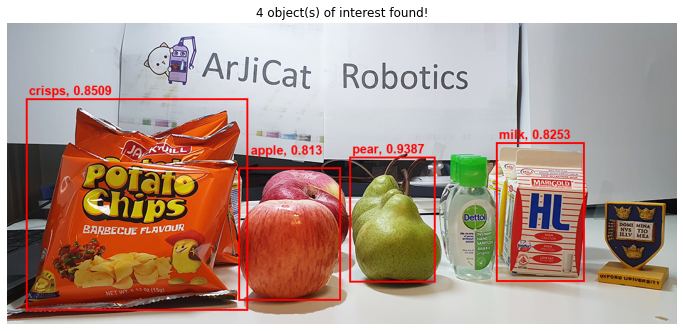

In [104]:
# Test single image
unseen_path = os.path.join(root, "custom_test_images")
img_path= os.path.join(unseen_path, "test6_small.jpg")

draw_outputs_unseen_data(img_path, "test6_small.jpg")

<Figure size 864x576 with 0 Axes>

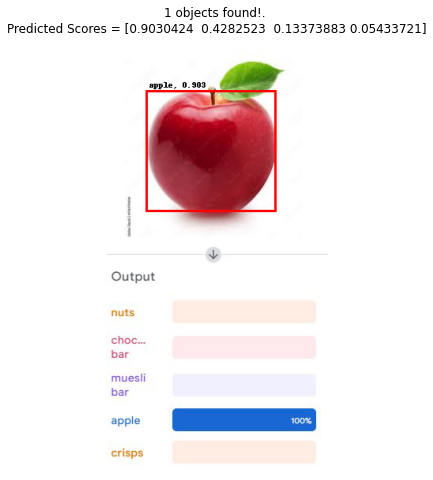

<Figure size 864x576 with 0 Axes>

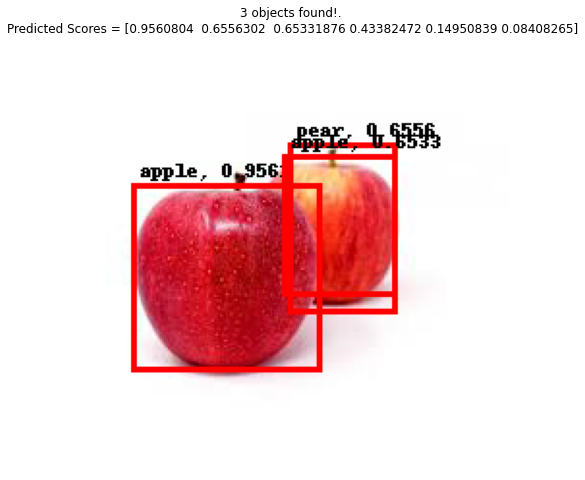

<Figure size 864x576 with 0 Axes>

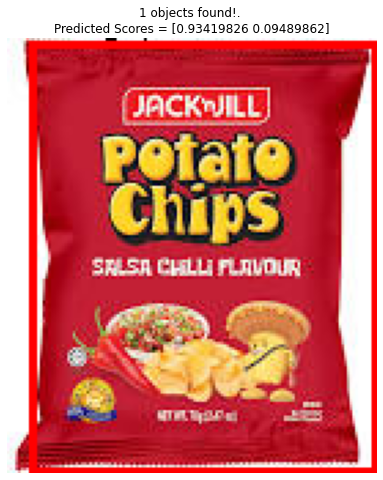

<Figure size 864x576 with 0 Axes>

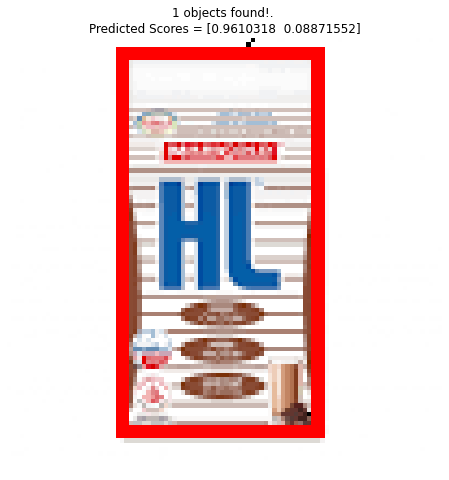

<Figure size 864x576 with 0 Axes>

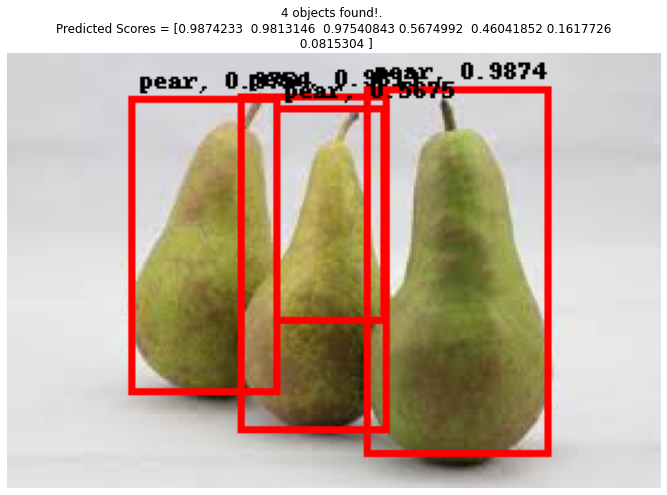

In [316]:
# Try with multiple images

unseen_path = os.path.join(root, "custom_test_images")

for filename in sorted(os.listdir(unseen_path)):
  img_path= os.path.join(unseen_path, filename)
  draw_outputs_unseen_data(img_path, filename)